# Ficha nr1 - Fashion mnist CNN


**Ruben Silva** - pg57900


### Imports

In [1]:
# PyTorch
import torch
import torch.nn as nn
from torch.serialization import safe_globals
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import Adam, SGD
from torch.nn import (
    Linear, ReLU, Softmax, CrossEntropyLoss, Sequential,
    Conv2d, MaxPool2d, BatchNorm2d, Dropout, Dropout2d, Flatten
)
from torch.nn.init import xavier_uniform_, kaiming_uniform_
from torchinfo import summary

# Torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor, Normalize, Compose

# Live loss plotting
from livelossplot import PlotLosses

# Sklearn
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Other libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from IPython.display import display


### Paths

In [2]:
PATH_TRAIN = r'C:\\Users\\ruben\\Desktop\\Minho\\MEI\\SI\\AP\\Mod2\\TPC1 CNN fashion mnist\\dataset\\fashion-mnist_train.csv'
PATH_TEST = r'C:\\Users\\ruben\\Desktop\\Minho\\MEI\\SI\\AP\\Mod2\\TPC1 CNN fashion mnist\\dataset\\fashion-mnist_test.csv'

## Tarefa 4 - CNN

**Setup**

In [3]:
BATCH_SIZE = 32

device = torch.device("cuda" if 
torch.cuda.is_available() else "cpu")

def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        self.dataset = dl.dataset
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)
    
device = get_default_device()
print(device)



cuda


**Prepare Data**

In [4]:
train_transform = Compose([ToTensor(), Normalize(mean=(0.1307,), std=(0.3081,))])
test_transform = Compose([ToTensor(), Normalize(mean=(0.1307,), std=(0.3081,))])

In [5]:
class CSVDataset(Dataset):
    def __init__(self, path, transform=None):
        self.transform = transform
        df_set = pd.read_csv(path)  # Remove header=None to use the first row as column names
        self.x = df_set.iloc[:, 1:].values  # Skip the 'label' column
        self.y = df_set.iloc[:, 0].values   # Use the 'label' column
        self.x = self.x.astype('float32')   # Convert pixel values to float32
        self.y = self.y.astype('long')      # Convert labels to long

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        label = self.y[idx]
        image = self.x[idx]       
        if self.transform is not None:
            image = self.transform(image)
        return image, label
    
    def get_TensorDataset(self):
        x = self.x.reshape(len(self.x), 1, 28, 28)
        xmax, xmin = x.max(), x.min()
        x = (x - xmin)/(xmax - xmin)  # Normalize to [0, 1]
        x = torch.from_numpy(np.array(x)).float()
        y = torch.from_numpy(np.array(self.y)).type(torch.LongTensor)
        cases = torch.utils.data.TensorDataset(x, y)
        return cases 


In [6]:
def prepare_data_loaders(path_train, path_test):
    dataset_train = CSVDataset(path_train,transform=train_transform)
    dataset_test = CSVDataset(path_test,transform=test_transform)
    train = dataset_train.get_TensorDataset()
    train_size = int(0.8 * len(train))
    val_size = len(train) - train_size
    train, validation = random_split(train, [train_size, val_size], generator=torch.Generator().manual_seed(42))
    test = dataset_test.get_TensorDataset()
    
    train_dl = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
    val_dl = DataLoader(validation, batch_size=BATCH_SIZE, shuffle=True)
    test_dl = DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)
    train_dl_all = DataLoader(train, batch_size=len(train), shuffle=False)
    val_dl_all = DataLoader(validation, batch_size=len(validation), shuffle=True)
    test_dl_all = DataLoader(test, batch_size=len(test), shuffle=False)
    return train_dl, val_dl, test_dl, train_dl_all, val_dl_all, test_dl_all

train_dl, val_dl, test_dl, train_dl_all, val_dl_all, test_dl_all = prepare_data_loaders(PATH_TRAIN, PATH_TEST)


**Visualize Data**

In [7]:
def output_label(label,mapping='label'):
    if mapping == 'ext':
        output_mapping = { 0:"zero", 1:"um", 2:"dois", 3:"tres", 4:"quatro", 5:"cinco", 6:"seis", 
        7:"sete", 
        8:"oito", 9:"nove" }
    elif mapping == 'ext2':
        output_mapping = { "0":"zero", "1":"um", "2":"dois", "3":"tres", "4":"quatro", "5":"cinco", 
        "6":"seis", "7":"sete", "8":"oito", "9":"nove" }
    else:
        output_mapping = { 0: "0", 1: "1", 2: "2", 3: "3", 4: "4", 5: "5", 6: "6", 7: "7", 8: "8", 9: "9"}
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

def visualize_data(path):
    df = pd.read_csv(path, header=0)
    display(df)

def visualize_dataset(train_dl, test_dl):
    print(f"Quantidade de casos de Treino:{len(train_dl.dataset)}") 
    print(f"Quantidade de casos de Validação:{len(val_dl.dataset)}")
    print(f"Quantidade de casos de Teste:{len(test_dl.dataset)}")
    x, y = next(iter(train_dl))
    print(f"Shape tensor batch casos treino, input: {x.shape}, output: {y.shape}")
    x, y = next(iter(val_dl))
    print(f"Shape tensor batch casos validação, input: {x.shape}, output: {y.shape}")
    x, y = next(iter(test_dl))  
    print(f"Shape tensor batch casos test, input: {x.shape}, output: {y.shape}")
    print(f'Valor máximo:{torch.max(x)} Valor mínimo:{torch.min(x)}')
    x=x.detach().numpy()
    print(f'Valor máximo:{np.max(x)} Valor mínimo:{np.min(x)}')
    print(y)

visualize_data(PATH_TRAIN)



,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,1,0,0,0,0,0,0,0,0,0,...,73,0,0,0,0,0,0,0,0,0
59997,8,0,0,0,0,0,0,0,0,0,...,160,162,163,135,94,0,0,0,0,0
59998,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


torch.Size([32, 1, 28, 28])


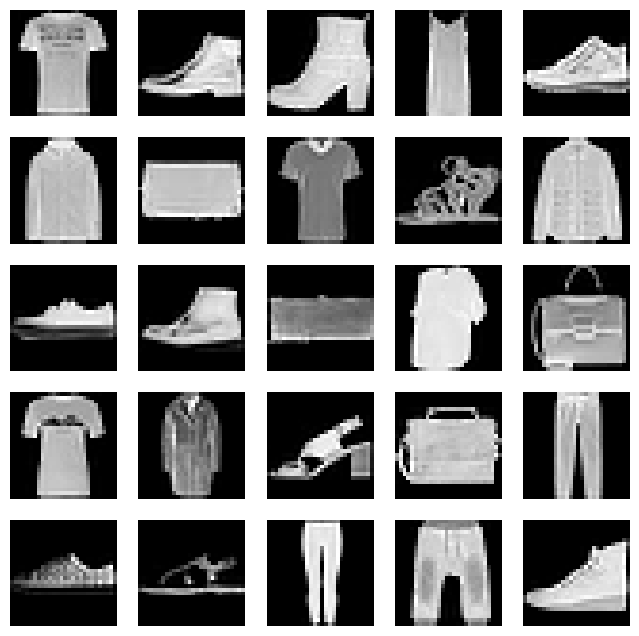

In [8]:
def visualize_mnist_images(dl):
    i, (inputs, targets) = next(enumerate(dl))
    print(inputs.shape)
    plt.figure(figsize=(8,8))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.axis('off')
        plt.grid(False)  #b=None
        plt.imshow(inputs[i][0], cmap='gray')
    plt.show()

visualize_mnist_images(train_dl)


-----Train------
casos: 48000
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
[4787 4841 4816 4798 4733 4789 4835 4798 4789 4814]
48000


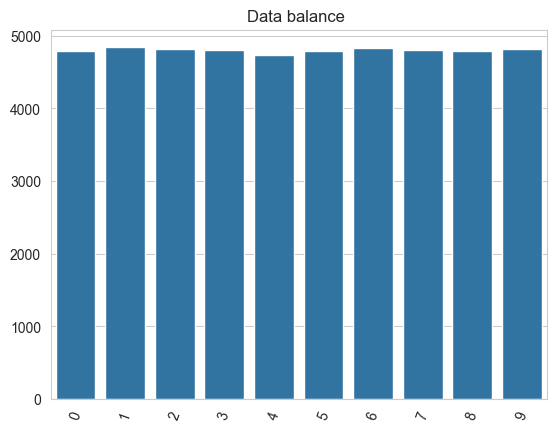

-----Test------
casos: 10000
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
[1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]
10000


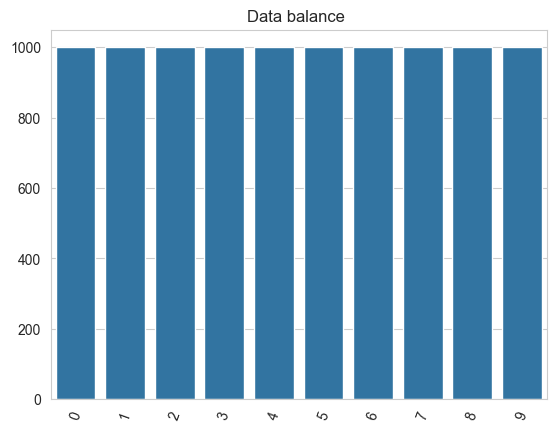

In [9]:
def visualize_holdout_balance(dl):
    _, labels = next(iter(dl))                             
    sns.set_style('whitegrid')
    print("casos:",len(labels))
    x, y = np.unique(labels, return_counts=True)
    x=[str(n) for n in x]
    print(x)
    print(y)
    print(np.sum(y))
    grafico = sns.barplot(x=x, y=y)
    grafico.set_title('Data balance ')
    plt.xticks(rotation=70)
    plt.show()
     
print("-----Train------")   
visualize_holdout_balance(train_dl_all)
print("-----Test------") 
visualize_holdout_balance(test_dl_all)


In [10]:
def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

**Model 1**

In [11]:
class CNNModel_1(nn.Module):
    def __init__(self):
        super(CNNModel_1, self).__init__()
        self.layer1 = Sequential(
            Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3)),
            ReLU(),
            MaxPool2d(kernel_size=(2,2), stride=(2,2))
        )
        self.layer2 = Sequential(
            Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3)),
            ReLU(),
            MaxPool2d(kernel_size=(2,2), stride=(2,2))
        )
        self.fc1 = Linear(in_features=5*5*32, out_features=100)
        kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
        self.act1 = ReLU()
        self.fc2 = Linear(in_features=100, out_features=10)
        xavier_uniform_(self.fc2.weight)
        self.act2 = Softmax(dim=1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(-1, 4*4*50) 
        out = self.fc1(out)
        out = self.act1(out)
        out = self.fc2(out)
        out = self.act2(out)
        return out

model = CNNModel_1()
model.to(device)
#print(summary(model, input_size=(BATCH_SIZE, 1, 28, 28), verbose=0))

CNNModel_1(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=800, out_features=100, bias=True)
  (act1): ReLU()
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (act2): Softmax(dim=1)
)

**Model 2**

In [12]:
class CNNModel_2(nn.Module):
    def __init__(self):
        super(CNNModel_2, self).__init__()
        self.layer1 = Sequential(Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=0),
        ReLU(),
        MaxPool2d(kernel_size=2)
        )
        self.layer2 = Sequential(Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0),
        ReLU(),
        MaxPool2d(kernel_size=2)
        )       
        self.fc1 = Linear(32 * 5 * 5, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1) 
        out = self.fc1(out) 
        return out
    
model = CNNModel_2()
#print(summary(model, input_size=(BATCH_SIZE, 1,28,28), verbose=0))

**Model 3**

In [13]:
class CNNModel_3(nn.Module):
    def __init__(self):
        super(CNNModel_3, self).__init__()
        self.layer1 = nn.Sequential(Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
        BatchNorm2d(32),
        ReLU(),
        MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(Conv2d(in_channels=32, out_channels=64, kernel_size=3),
        BatchNorm2d(64),
        ReLU(),
        MaxPool2d(2)
        )
        self.fc1 = Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = Linear(in_features=600, out_features=120)
        self.fc3 = Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out
model = CNNModel_3()
#print(summary(model, input_size=(BATCH_SIZE, 1,28,28), verbose=0))



**Model 4**

In [14]:
class CNNModel_4(nn.Module):
    def __init__(self):
        super(CNNModel_4, self).__init__()
        self.layer1 = Sequential(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=0),
        BatchNorm2d(32),
        ReLU(),
        MaxPool2d(2),
        Dropout2d(0.2)
        )
        self.fc1 = Linear(in_features=32*12*12, out_features=128)
        self.fc2 = Linear(in_features=128, out_features=10)
    
    def forward(self, x):
        out = self.layer1(x)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
    
model = CNNModel_4()
#print(summary(model, input_size=(BATCH_SIZE, 1,28,28), verbose=0))

**Train Model**

In [15]:
def train_model(h5_file, train_dl, val_dl, model, criterion, optimizer, epochs):
    liveloss = PlotLosses()
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0.0
        for inputs, labels in train_dl:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data).item()  # Use .item()
        epoch_loss = running_loss / len(train_dl.dataset)
        epoch_acc = running_corrects / len(train_dl.dataset)

        model.eval()
        running_loss = 0.0
        running_corrects = 0.0
        for inputs, labels in val_dl:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data).item()  # Use .item()
        val_loss = running_loss / len(val_dl.dataset)
        val_acc = running_corrects / len(val_dl.dataset)
        
        liveloss.update({
            'loss': epoch_loss,
            'accuracy': epoch_acc,
            'val_loss': val_loss,
            'val_accuracy': val_acc
        })
        liveloss.send()
    torch.save(model,h5_file)


In [16]:
def train_model_cnn(n=1):
    if n == 1:
        model = CNNModel_1()
    elif n == 2:
        model = CNNModel_2()
    elif n == 3:    
        model = CNNModel_3()
    elif n == 4:    
        model = CNNModel_4()
    else:
        raise ValueError("Invalid model number. Choose between 1 and 4.")
    
    print(summary(model, input_size=(BATCH_SIZE, 1,28,28), verbose=0))
    model.apply(initialize_weights)
    model.to(device)
    Epochs = 15
    LEARNING_RATE = 0.001
    criterion = CrossEntropyLoss() 
    optimizer = SGD(model.parameters(), lr=LEARNING_RATE) 
    starttime = time.perf_counter()
    if n == 1:
        train_model('CNNModel_1.pth', train_dl, val_dl, model, criterion, optimizer,Epochs)
    elif n == 2:
        train_model('CNNModel_2.pth', train_dl, val_dl, model, criterion, optimizer,Epochs)
    elif n == 3:
        train_model('CNNModel_3.pth', train_dl, val_dl, model, criterion, optimizer,Epochs)
    elif n == 4:
        train_model('CNNModel_4.pth', train_dl, val_dl, model, criterion, optimizer,Epochs)
    endtime = time.perf_counter()
    print(f"Tempo gasto: {endtime - starttime} segundos")


**Evaluate Model**

In [17]:
def evaluate_model(test_dl, model):
    predictions = list()
    actual_values = list()
    for inputs, labels in test_dl:
        inputs = inputs.to(device)
        labels = labels.to(device)
        yprev = model(inputs)
        yprev = yprev.detach().cpu().numpy()
        actual = labels.cpu().numpy()
        yprev = np.argmax(yprev, axis=1)
        actual = actual.reshape((len(actual), 1))
        yprev = yprev.reshape((len(yprev), 1))
        predictions.append(yprev)
        actual_values.append(actual)
        break
    predictions, actual_values = np.vstack(predictions), np.vstack(actual_values)
    return actual_values, predictions

In [18]:
def display_predictions(actual_values, predictions):
    acertou=0
    falhou = 0
    primeiros=0
    for r,p in zip(actual_values, predictions):
        if primeiros <20:
            print(f'real:{r} previsão:{p}') 
            primeiros +=1
        if r==p: acertou+=1  
        else: falhou+=1
    corrects = np.sum(predictions == actual_values)
    acc = corrects/len(test_dl.dataset)
    acc = accuracy_score(actual_values, 
    predictions)
    print(f'Accuracy: {acc:0.3f}\n')
    print(f'acertou:{acertou} falhou:{falhou}')
    acc = accuracy_score(actual_values, 
    predictions)
    print(f'Accuracy: {acc:0.3f}\n')
    print(f'acertou:{acertou} falhou:{falhou}')


In [19]:
def display_confusion_matrix(cm,list_classes):
    plt.figure(figsize = (16,8))
    sns.heatmap(cm,annot=True,xticklabels=list_classes,yticklabels=list_classes, annot_kws={"size": 12}, 
    fmt='g', linewidths=.5)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [20]:
def evaluate_model_cnn(n=1):
    if n == 1:
        with safe_globals([CNNModel_1, nn.Sequential, nn.Conv2d, nn.ReLU, nn.MaxPool2d, nn.Linear, nn.Softmax]):
            model = torch.load('CNNModel_1.pth', map_location=device)
    elif n == 2:
        with safe_globals([CNNModel_2, nn.Sequential, nn.Conv2d, nn.ReLU, nn.MaxPool2d, nn.Linear, nn.Softmax, nn.BatchNorm2d, nn.Dropout2d]):
            model = torch.load('CNNModel_2.pth', map_location=device)
    elif n == 3:
        with safe_globals([CNNModel_3, nn.Sequential, nn.Conv2d, nn.ReLU, nn.MaxPool2d, nn.Linear, nn.Softmax, nn.BatchNorm2d, nn.Dropout2d]):
            model = torch.load('CNNModel_3.pth', map_location=device)
    elif n == 4:
        with safe_globals([CNNModel_4, nn.Sequential, nn.Conv2d, nn.ReLU, nn.MaxPool2d, nn.Linear, nn.Softmax, nn.BatchNorm2d, nn.Dropout2d]):
            model = torch.load('CNNModel_4.pth', map_location=device)
    else:
        raise ValueError("Invalid model number. Choose between 1 and 4.")
    
    model.eval()
    model.to(device)
    actual_values, predictions = evaluate_model(test_dl_all, model)
    display_predictions(actual_values, predictions)
    print(classification_report(actual_values, predictions))
    cr = classification_report(actual_values, predictions, output_dict=True)
    list_classes = [output_label(n, 'ext2') for n in list(cr.keys())[0:10]]
    cm = confusion_matrix(actual_values, predictions)
    print(cm)
    display_confusion_matrix(cm, list_classes)

**Use Model Functions**

In [21]:
def make_prediction(model, img):
    img = img.reshape(1, 1, 28, 28)
    print(img.shape)
    print(img.dtype)
    img = img.to(device) #valves
    prediction = model(img).cpu().detach().numpy()[0].argmax()
    print("predict:",prediction)
    img=img.cpu()
    plt.axis('off')
    plt.grid(False)  #b=None
    plt.imshow(img[0,0], cmap=plt.get_cmap('gray'))
    plt.show()

def make_prediction_cnn(n=1):
    if n == 1:
        with safe_globals([CNNModel_1, nn.Sequential, nn.Conv2d, nn.ReLU, nn.MaxPool2d, nn.Linear, nn.Softmax]):
            model = torch.load('CNNModel_1.pth', map_location=device)
    elif n == 2:
        with safe_globals([CNNModel_2, nn.Sequential, nn.Conv2d, nn.ReLU, nn.MaxPool2d, nn.Linear, nn.Softmax, nn.BatchNorm2d, nn.Dropout2d]):
            model = torch.load('CNNModel_2.pth', map_location=device)
    elif n == 3:
        with safe_globals([CNNModel_3, nn.Sequential, nn.Conv2d, nn.ReLU, nn.MaxPool2d, nn.Linear, nn.Softmax, nn.BatchNorm2d, nn.Dropout2d]):
            model = torch.load('CNNModel_3.pth', map_location=device)
    elif n == 4:
        with safe_globals([CNNModel_4, nn.Sequential, nn.Conv2d, nn.ReLU, nn.MaxPool2d, nn.Linear, nn.Softmax, nn.BatchNorm2d, nn.Dropout2d]):
            model = torch.load('CNNModel_4.pth', map_location=device)
    else:
        raise ValueError("Invalid model number. Choose between 1 and 4.")
    imagens, label = next(iter(test_dl))
    make_prediction(model,imagens[3])

**Train Model 1**

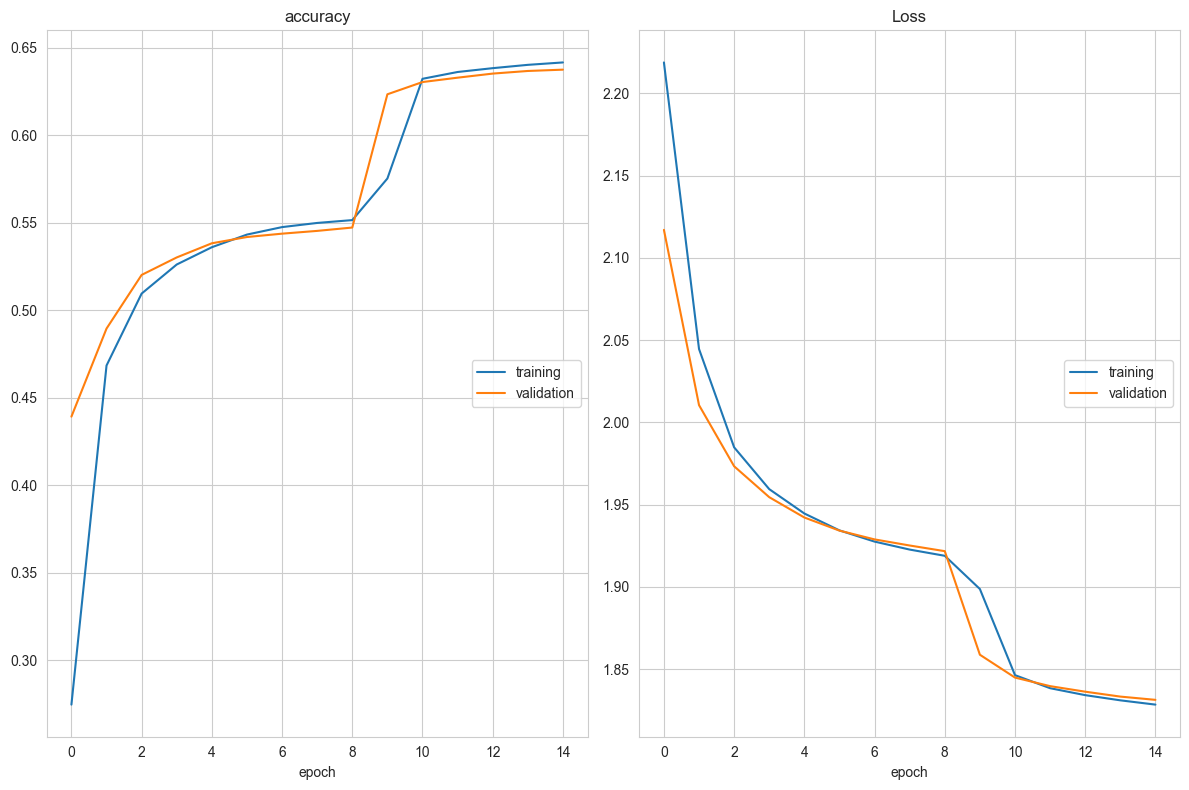

accuracy
	training         	 (min:    0.275, max:    0.642, cur:    0.642)
	validation       	 (min:    0.439, max:    0.638, cur:    0.638)
Loss
	training         	 (min:    1.829, max:    2.219, cur:    1.829)
	validation       	 (min:    1.831, max:    2.117, cur:    1.831)
Tempo gasto: 109.66921800000273 segundos


In [22]:
train_model_cnn(1)


**Train Model 2**

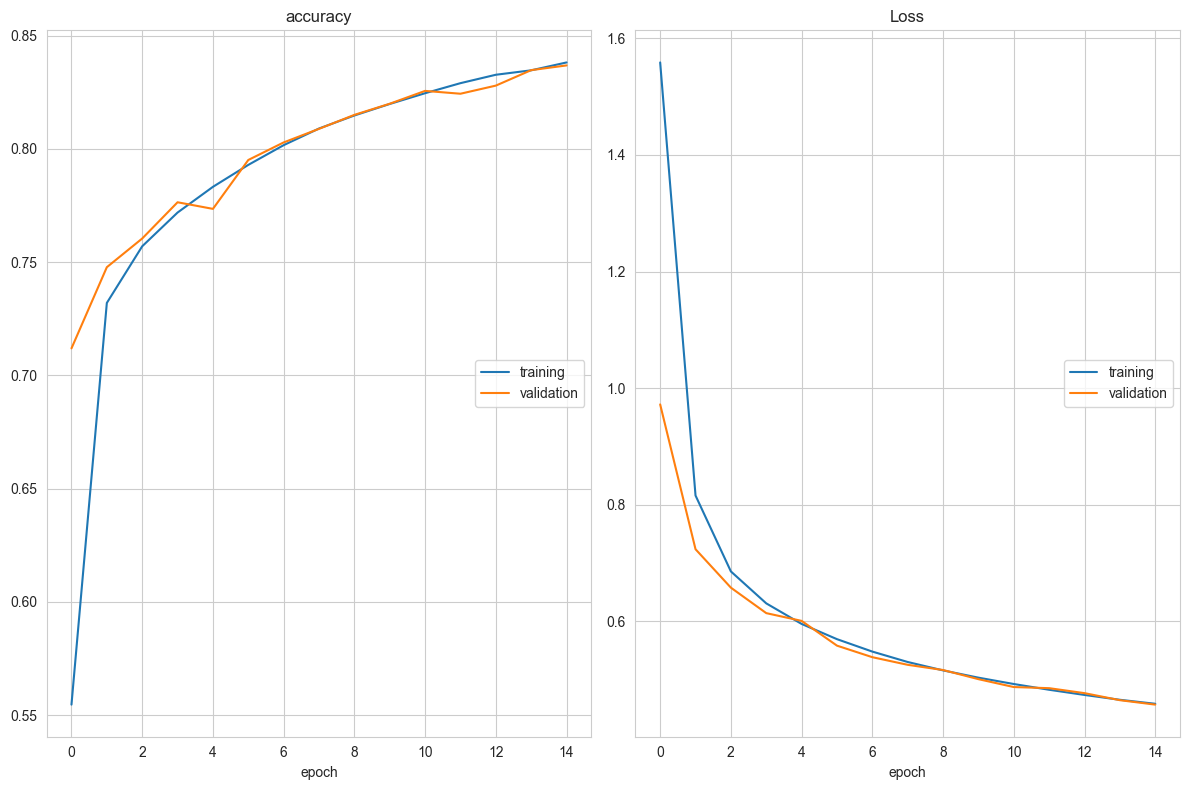

accuracy
	training         	 (min:    0.555, max:    0.838, cur:    0.838)
	validation       	 (min:    0.712, max:    0.837, cur:    0.837)
Loss
	training         	 (min:    0.459, max:    1.559, cur:    0.459)
	validation       	 (min:    0.457, max:    0.972, cur:    0.457)
Tempo gasto: 90.84590949999983 segundos


In [23]:
train_model_cnn(2)

**Train Model 3**

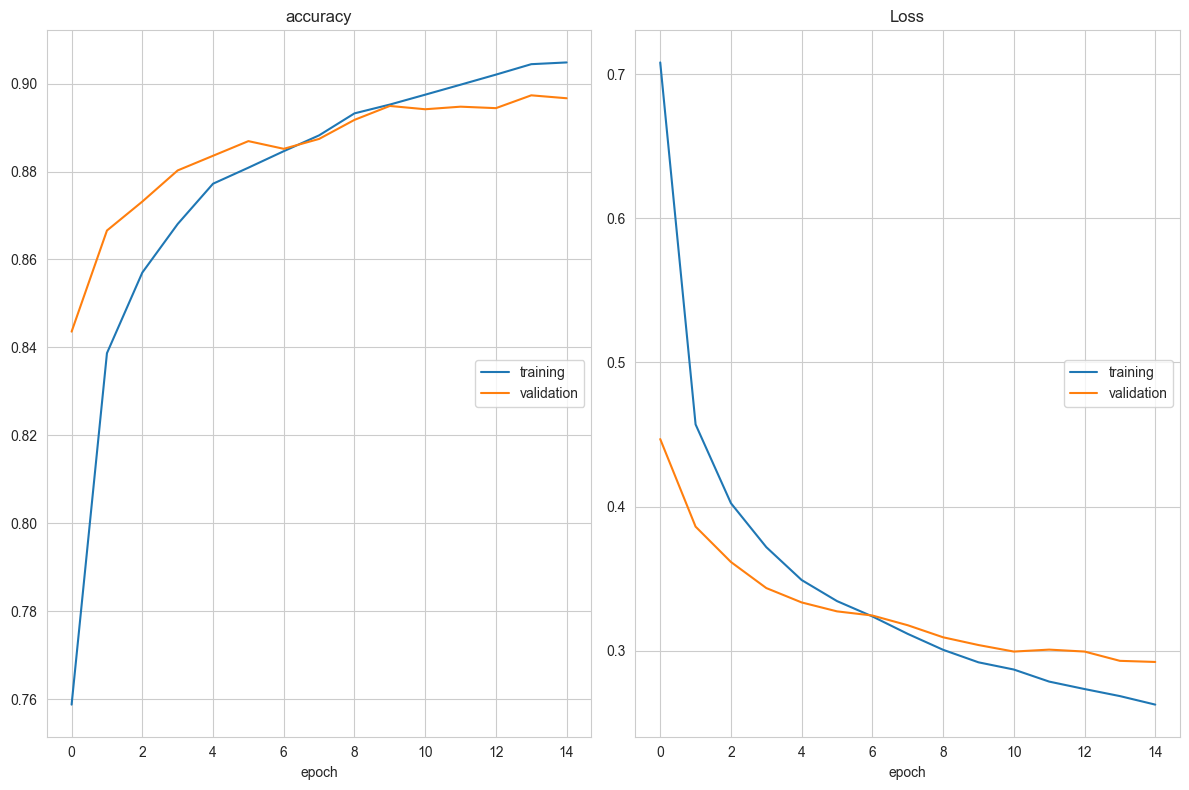

accuracy
	training         	 (min:    0.759, max:    0.905, cur:    0.905)
	validation       	 (min:    0.844, max:    0.897, cur:    0.897)
Loss
	training         	 (min:    0.263, max:    0.708, cur:    0.263)
	validation       	 (min:    0.292, max:    0.447, cur:    0.292)
Tempo gasto: 124.9157355999996 segundos


In [24]:
train_model_cnn(3)

**Train Model 4**

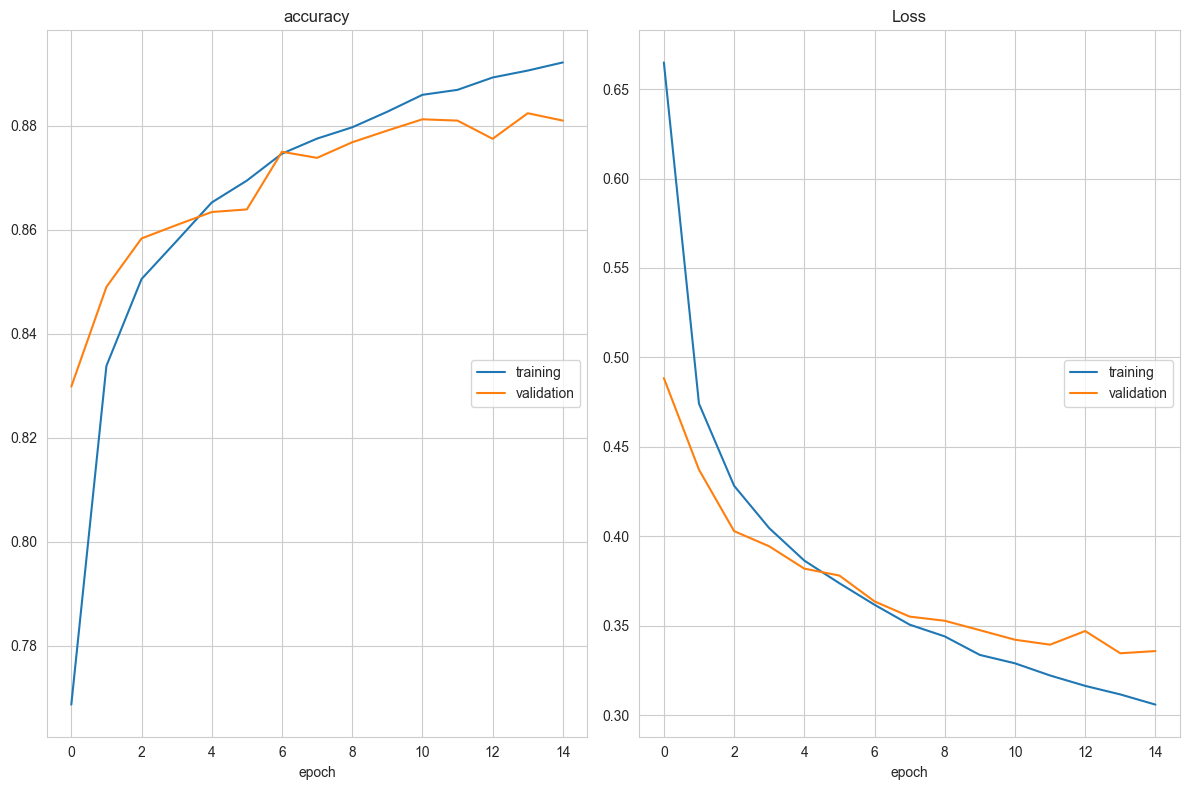

accuracy
	training         	 (min:    0.769, max:    0.892, cur:    0.892)
	validation       	 (min:    0.830, max:    0.882, cur:    0.881)
Loss
	training         	 (min:    0.306, max:    0.665, cur:    0.306)
	validation       	 (min:    0.335, max:    0.488, cur:    0.336)
Tempo gasto: 90.31545059999917 segundos


In [25]:
train_model_cnn(4)

**Evaluate Model 1**

real:[0] previsão:[0]
real:[1] previsão:[1]
real:[2] previsão:[2]
real:[2] previsão:[0]
real:[3] previsão:[1]
real:[2] previsão:[2]
real:[8] previsão:[8]
real:[6] previsão:[2]
real:[5] previsão:[5]
real:[0] previsão:[0]
real:[3] previsão:[0]
real:[4] previsão:[2]
real:[4] previsão:[2]
real:[6] previsão:[2]
real:[8] previsão:[8]
real:[5] previsão:[5]
real:[6] previsão:[2]
real:[3] previsão:[1]
real:[6] previsão:[2]
real:[4] previsão:[2]
Accuracy: 0.637

acertou:6373 falhou:3627
Accuracy: 0.637

acertou:6373 falhou:3627
              precision    recall  f1-score   support

           0       0.47      0.89      0.62      1000
           1       0.67      0.95      0.79      1000
           2       0.35      0.94      0.52      1000
           3       0.00      0.00      0.00      1000
           4       0.00      0.00      0.00      1000
           5       0.90      0.90      0.90      1000
           6       0.00      0.00      0.00      1000
           7       0.85      0.84      0.84

c:\Users\ruben\Desktop\Minho\MEI\SI\AP\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ruben\Desktop\Minho\MEI\SI\AP\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ruben\Desktop\Minho\MEI\SI\AP\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

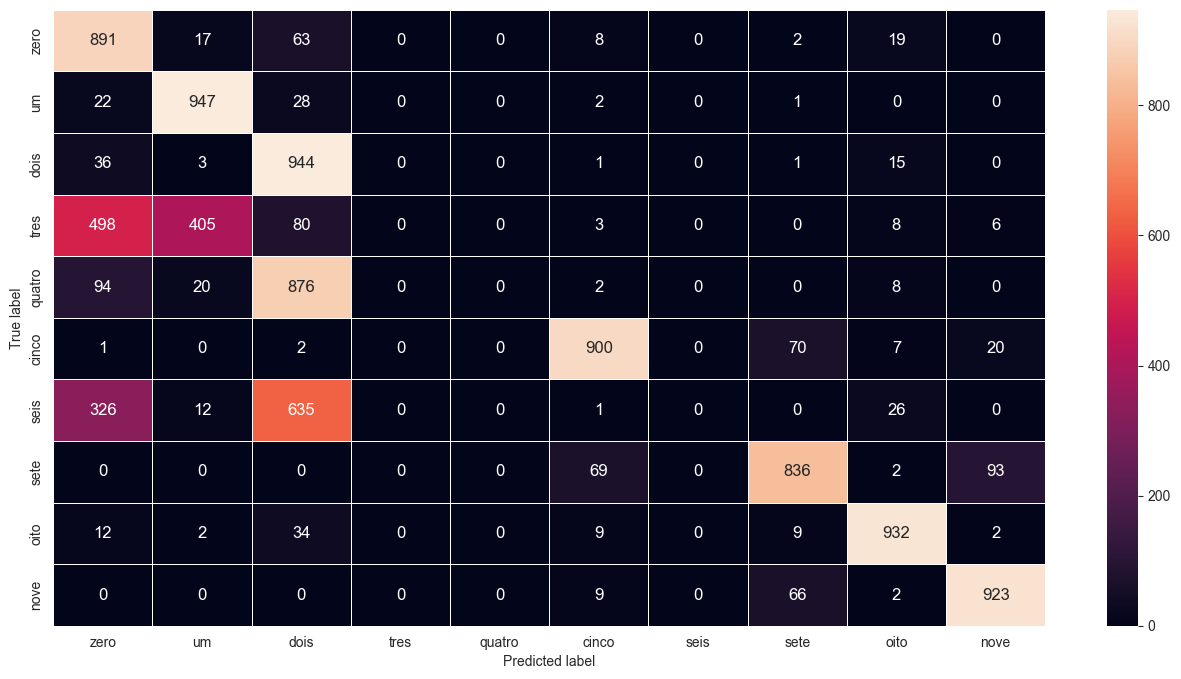

In [26]:
evaluate_model_cnn(1)

**Evaluate Model 2**

real:[0] previsão:[0]
real:[1] previsão:[1]
real:[2] previsão:[2]
real:[2] previsão:[6]
real:[3] previsão:[3]
real:[2] previsão:[2]
real:[8] previsão:[8]
real:[6] previsão:[6]
real:[5] previsão:[5]
real:[0] previsão:[0]
real:[3] previsão:[3]
real:[4] previsão:[4]
real:[4] previsão:[4]
real:[6] previsão:[6]
real:[8] previsão:[8]
real:[5] previsão:[5]
real:[6] previsão:[4]
real:[3] previsão:[3]
real:[6] previsão:[6]
real:[4] previsão:[4]
Accuracy: 0.844

acertou:8435 falhou:1565
Accuracy: 0.844

acertou:8435 falhou:1565
              precision    recall  f1-score   support

           0       0.76      0.85      0.80      1000
           1       0.97      0.95      0.96      1000
           2       0.77      0.70      0.73      1000
           3       0.89      0.86      0.88      1000
           4       0.72      0.81      0.77      1000
           5       0.92      0.93      0.93      1000
           6       0.62      0.54      0.58      1000
           7       0.90      0.88      0.89

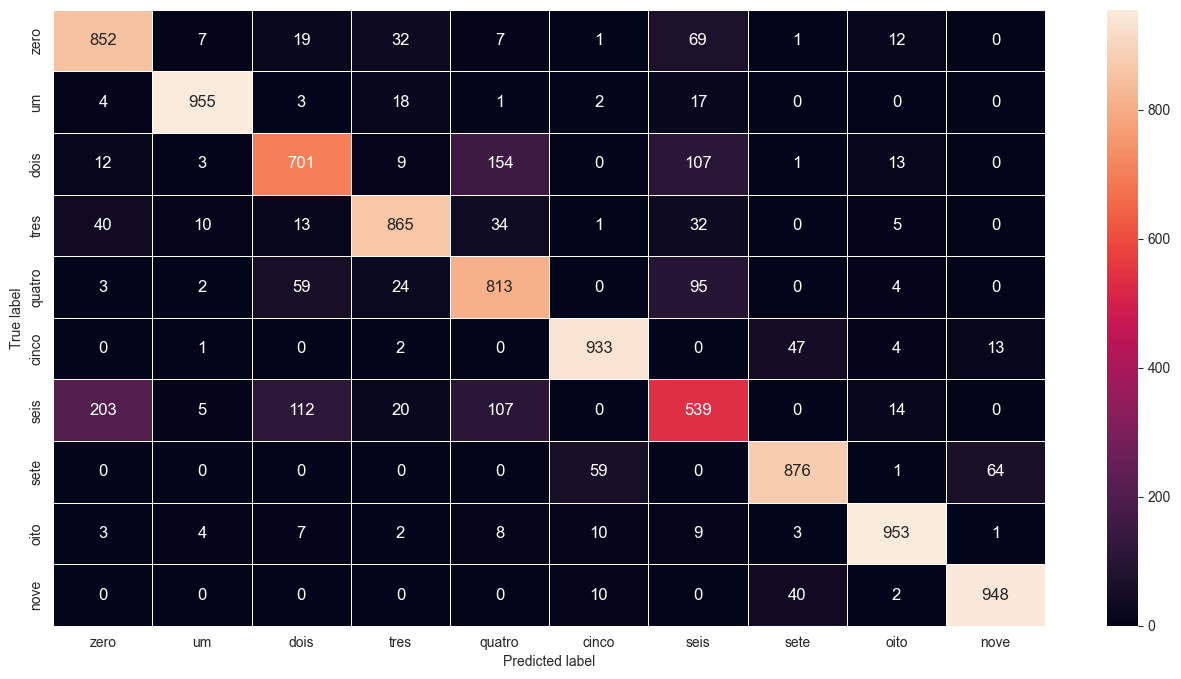

In [27]:
evaluate_model_cnn(2)

**Evaluate Model 3**

c:\Users\ruben\Desktop\Minho\MEI\SI\AP\.venv\Lib\site-packages\torch\nn\functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


real:[0] previsão:[0]
real:[1] previsão:[1]
real:[2] previsão:[2]
real:[2] previsão:[6]
real:[3] previsão:[3]
real:[2] previsão:[6]
real:[8] previsão:[8]
real:[6] previsão:[6]
real:[5] previsão:[5]
real:[0] previsão:[0]
real:[3] previsão:[3]
real:[4] previsão:[2]
real:[4] previsão:[4]
real:[6] previsão:[6]
real:[8] previsão:[8]
real:[5] previsão:[5]
real:[6] previsão:[6]
real:[3] previsão:[3]
real:[6] previsão:[6]
real:[4] previsão:[4]
Accuracy: 0.901

acertou:9013 falhou:987
Accuracy: 0.901

acertou:9013 falhou:987
              precision    recall  f1-score   support

           0       0.88      0.83      0.85      1000
           1       0.98      0.97      0.98      1000
           2       0.89      0.81      0.85      1000
           3       0.91      0.90      0.91      1000
           4       0.82      0.89      0.85      1000
           5       0.97      0.97      0.97      1000
           6       0.71      0.77      0.74      1000
           7       0.95      0.94      0.94  

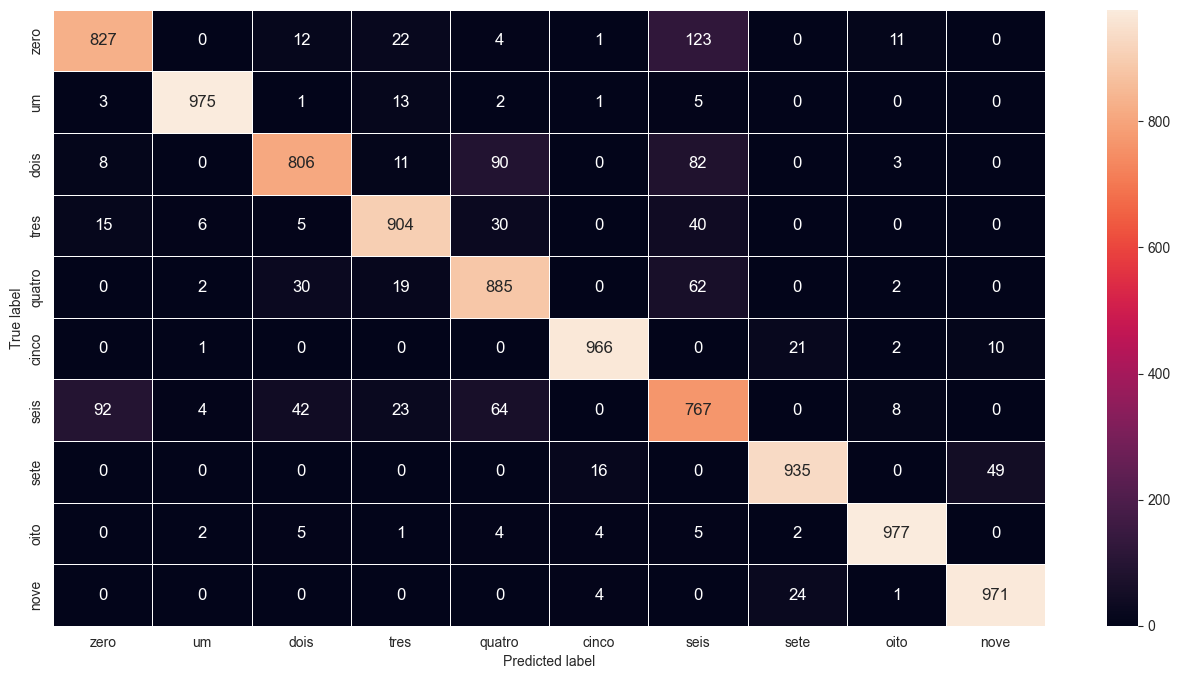

In [28]:
evaluate_model_cnn(3)

**Evaluate Model 4**

real:[0] previsão:[0]
real:[1] previsão:[1]
real:[2] previsão:[2]
real:[2] previsão:[6]
real:[3] previsão:[3]
real:[2] previsão:[6]
real:[8] previsão:[8]
real:[6] previsão:[6]
real:[5] previsão:[5]
real:[0] previsão:[0]
real:[3] previsão:[3]
real:[4] previsão:[4]
real:[4] previsão:[4]
real:[6] previsão:[6]
real:[8] previsão:[8]
real:[5] previsão:[5]
real:[6] previsão:[4]
real:[3] previsão:[3]
real:[6] previsão:[6]
real:[4] previsão:[4]
Accuracy: 0.892

acertou:8918 falhou:1082
Accuracy: 0.892

acertou:8918 falhou:1082
              precision    recall  f1-score   support

           0       0.88      0.78      0.83      1000
           1       0.98      0.97      0.98      1000
           2       0.82      0.85      0.83      1000
           3       0.85      0.94      0.89      1000
           4       0.84      0.87      0.85      1000
           5       0.96      0.95      0.96      1000
           6       0.74      0.69      0.71      1000
           7       0.91      0.96      0.94

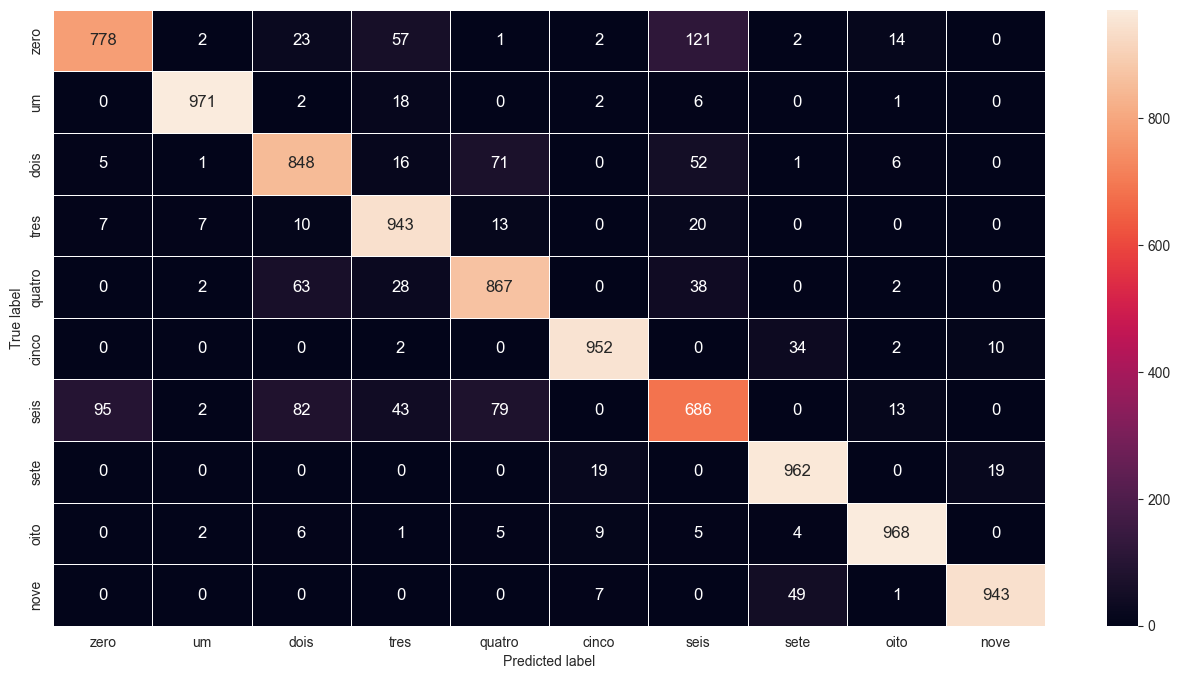

In [29]:
evaluate_model_cnn(4)

**Use Model 1**

torch.Size([1, 1, 28, 28])
torch.float32
predict: 5


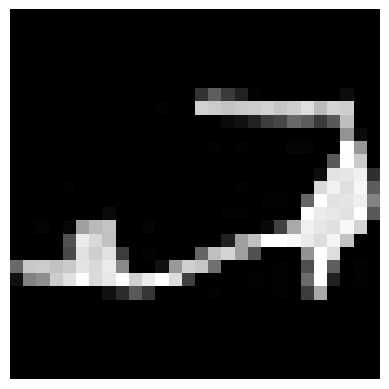

In [30]:
make_prediction_cnn(1)

**Use Model 2**

torch.Size([1, 1, 28, 28])
torch.float32
predict: 3


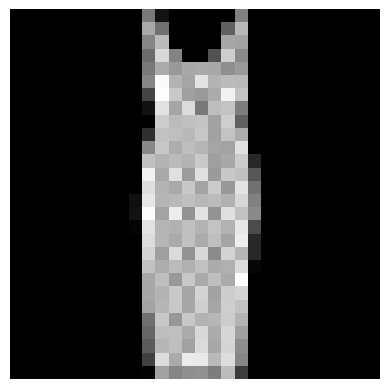

In [31]:
make_prediction_cnn(2)

**Use Model 3**

torch.Size([1, 1, 28, 28])
torch.float32
predict: 4


c:\Users\ruben\Desktop\Minho\MEI\SI\AP\.venv\Lib\site-packages\torch\nn\functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


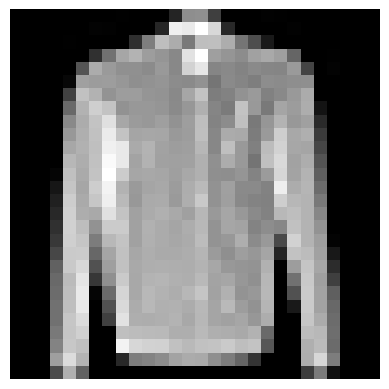

In [32]:
make_prediction_cnn(3)

**Use Model 4**

torch.Size([1, 1, 28, 28])
torch.float32
predict: 5


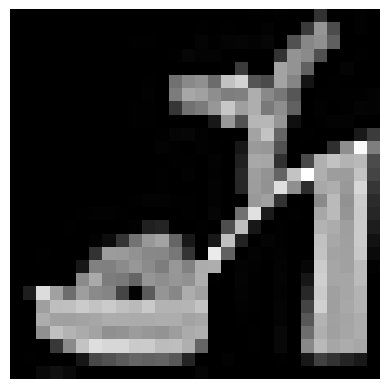

In [33]:
make_prediction_cnn(4)